# Unsupervised learning: PCA and clustering


## 1. Introduction

The main feature of unsupervised learning algorithms, when compared to classification and regression methods, is that input data are unlabeled (i.e. no labels or classes given) and that the algorithm learns the structure of the data without any assistance. This creates two main differences. First, it allows us to process large amounts of data because the data does not need to be manually labeled. Second, it is difficult to evaluate the quality of an unsupervised algorithm due to the absence of an explicit goodness metric as used in supervised learning.  

One of the most common tasks in unsupervised learning is dimensionality reduction. On one hand, dimensionality reduction may help with data visualization (e.g. t-SNE method) while, on the other hand, it may help deal with the multicollinearity of your data and prepare the data for a supervised learning method (e.g. decision trees).


## 2. Principal Component Analysis (PCA)

### Intuition, theories, and application issues

Principal Component Analysis is one of the easiest, most intuitive, and most frequently used methods for dimensionality reduction, projecting data onto its orthogonal feature subspace.


<img align="right" src="https://habrastorage.org/getpro/habr/post_images/bb6/fe7/f06/bb6fe7f06e114bcc9c354a1cb025b966.png" width="400">


More generally speaking, all observations can be considered as an ellipsoid in a subspace of an initial feature space, and the new basis set in this subspace is aligned with the ellipsoid axes. This assumption lets us remove highly correlated features since basis set vectors are orthogonal.
In the general case, the resulting ellipsoid dimensionality matches the initial space dimensionality, but the assumption that our data lies in a subspace with a smaller dimension allows us to cut off the "excessive" space with the new projection (subspace). We accomplish this in a 'greedy' fashion, sequentially selecting each of the ellipsoid axes by identifying where the dispersion is maximal.


> "To deal with hyper-planes in a 14 dimensional space, visualize a 3D space and say 'fourteen' very loudly. Everyone does it." - Geoffrey Hinton


Let's take a look at the mathematical formulation of this process:

In order to decrease the dimensionality of our data from $n$ to $k$ with $k \leq n$, we sort our list of axes in order of decreasing dispersion and take the top-$k$ of them.

We begin by computing the dispersion and the covariance of the initial features. This is usually done with the covariance matrix. According to the covariance definition, the covariance of two features is computed as follows:

$$cov(X_i, X_j) = E[(X_i - \mu_i) (X_j - \mu_j)] = E[X_i X_j] - \mu_i \mu_j,$$

where $\mu_i$ is the expected value of the $i$th feature. It is worth noting that the covariance is symmetric, and the covariance of a vector with itself is equal to its dispersion.

Therefore the covariance matrix is symmetric with the dispersion of the corresponding features on the diagonal. Non-diagonal values are the covariances of the corresponding pair of features. In terms of matrices where $\mathbf{X}$ is the matrix of observations, the covariance matrix is as follows:

$$\Sigma = E[(\mathbf{X} - E[\mathbf{X}]) (\mathbf{X} - E[\mathbf{X}])^{T}]$$

Quick recap: matrices, as linear operators, have eigenvalues and eigenvectors. They are very convenient because they describe parts of our space that do not rotate and only stretch when we apply linear operators on them; eigenvectors remain in the same direction but are stretched by a corresponding eigenvalue. Formally, a matrix $M$ with eigenvector $w_i$ and eigenvalue $\lambda_i$ satisfy this equation: $M w_i = \lambda_i w_i$.

The covariance matrix for a sample $\mathbf{X}$ can be written as a product of $\mathbf{X}^{T} \mathbf{X}$. According to the [Rayleigh quotient](https://en.wikipedia.org/wiki/Rayleigh_quotient), the maximum variation of our sample lies along the eigenvector of this matrix and is consistent with the maximum eigenvalue. Therefore, the principal components we aim to retain from the data are just the eigenvectors corresponding to the top-$k$ largest eigenvalues of the matrix.

The next steps are easier to digest. We multiply the matrix of our data $X$ by these components to get the projection of our data onto the orthogonal basis of the chosen components. If the number of components was smaller than the initial space dimensionality, remember that we will lose some information upon applying this transformation.

## Examples
### Fisher's iris dataset

Let's start by uploading all of the essential modules and try out the iris example from the `scikit-learn` documentation.

In [1]:
#adopted from github.com/Yorko/mlcourse.ai/

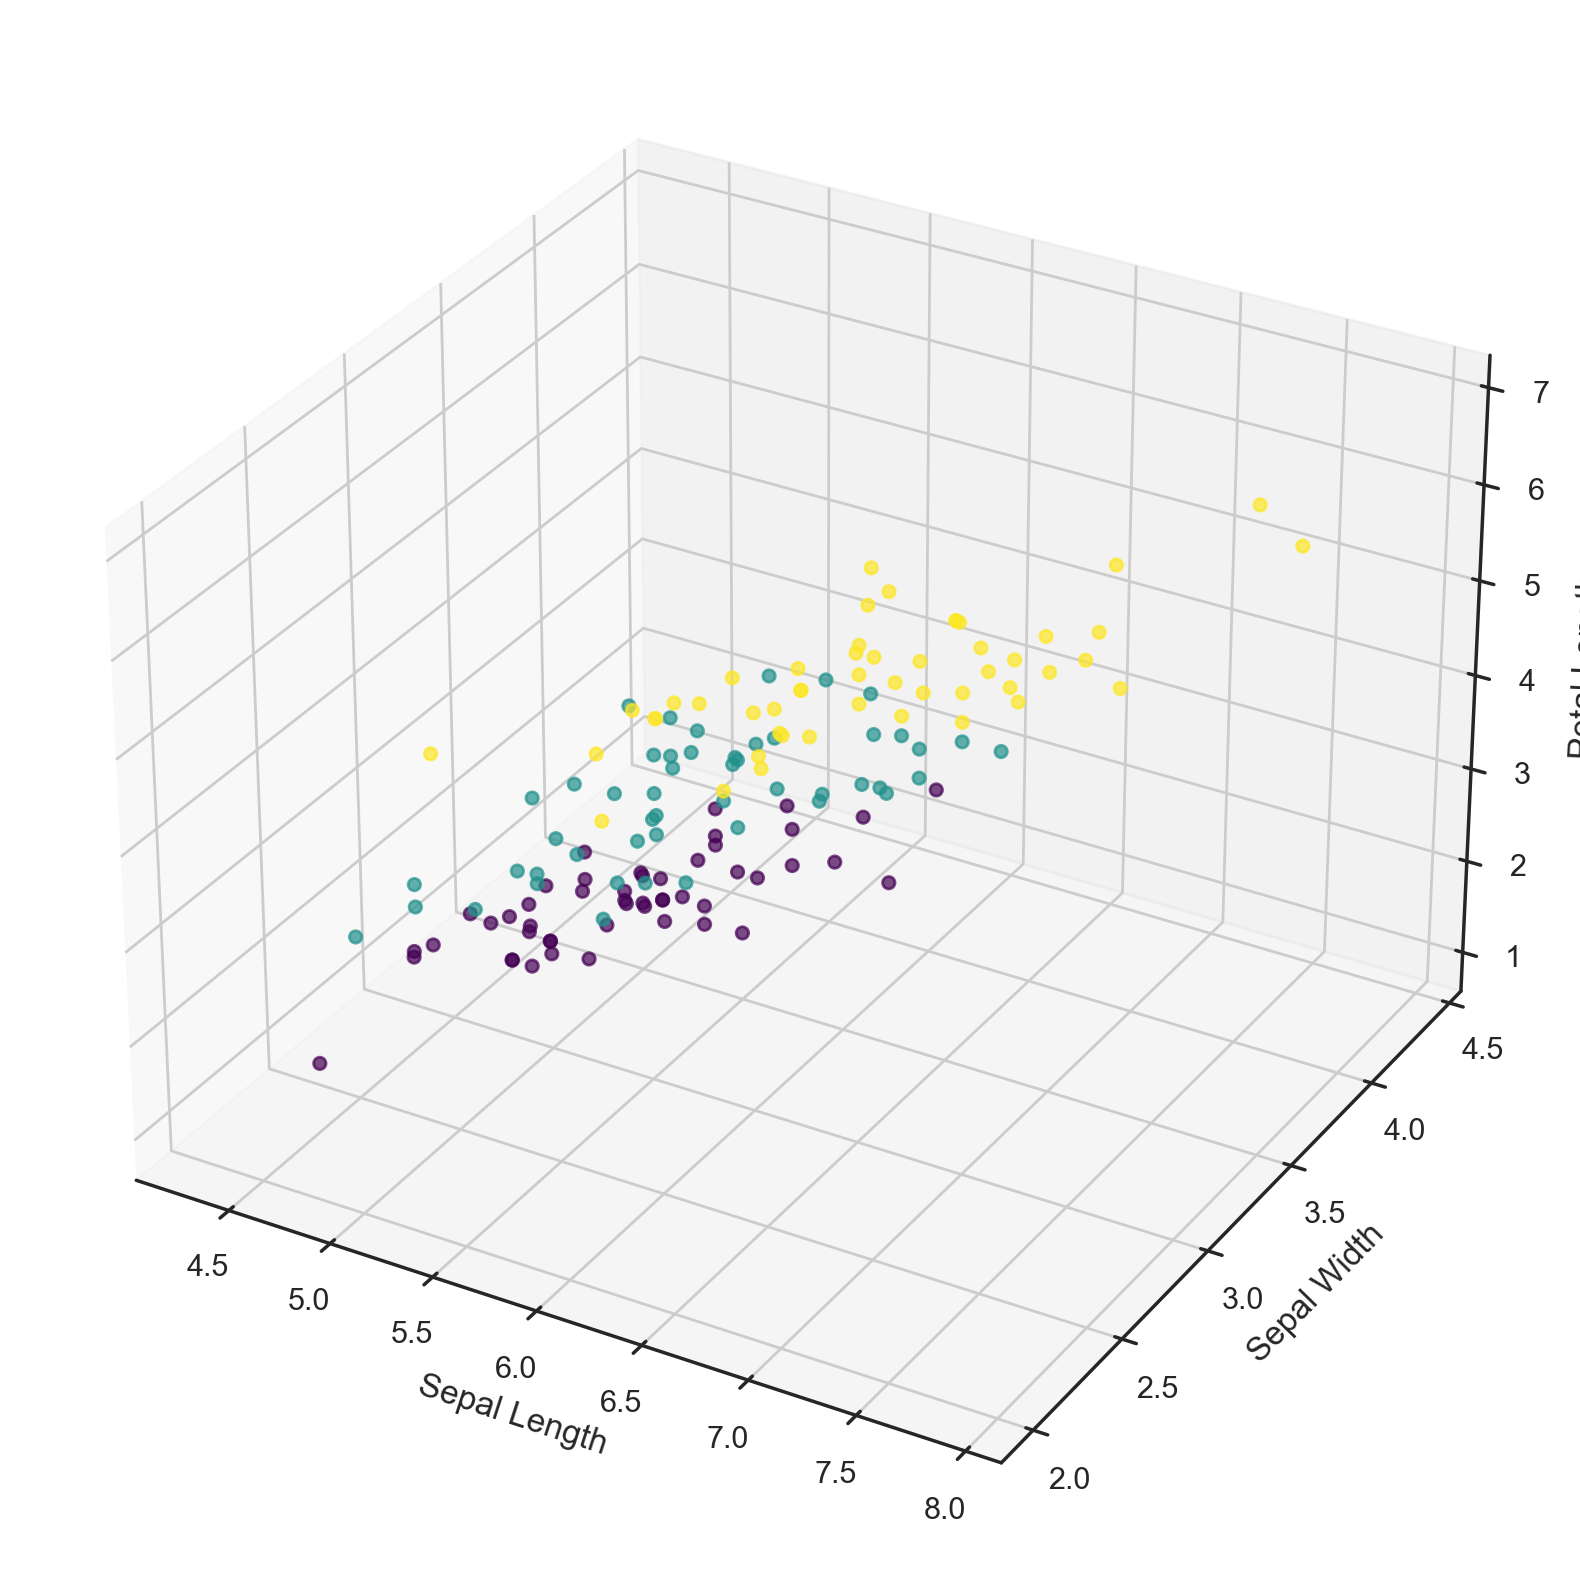

In [2]:
import numpy as np
import pandas as pd
from sklearn import datasets, decomposition

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load the iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Plot the dataset in 3D ignoring Petal Width
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2],  
           c=y, cmap='viridis', alpha=0.7)
ax.set_xlabel('Sepal Length')
ax.set_ylabel('Sepal Width')
ax.set_zlabel('Petal Length');

Now let's see how PCA will improve the results of a simple model that is not able to correctly fit all of the training data:

In [3]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Train, test splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Decision trees with depth = 2
clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print("Accuracy: {:.5f}".format(accuracy_score(y_test, preds.argmax(axis=1))))

Accuracy: 0.88889


Let's try this again, but, this time, let's reduce the dimensionality to 2 dimensions:

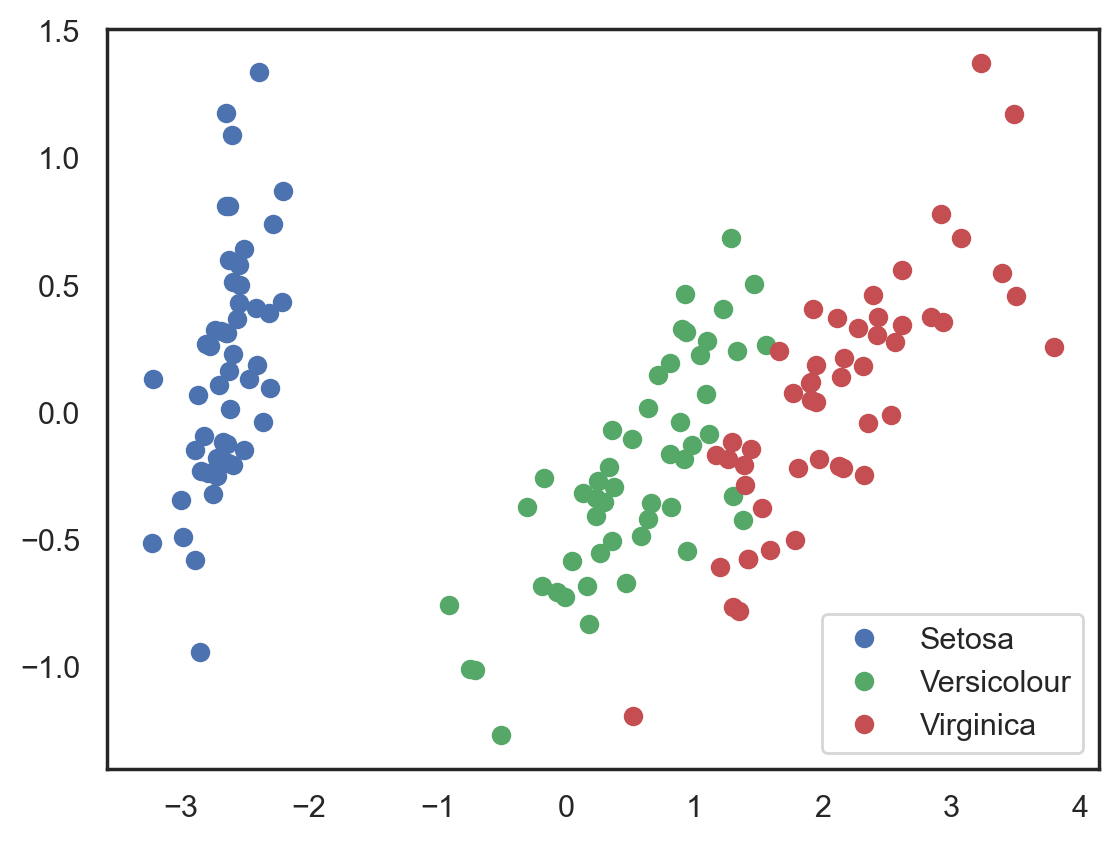

In [4]:
# Using PCA from sklearn PCA
pca = decomposition.PCA(n_components=2)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

# Plotting the results of PCA
plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], "bo", label="Setosa")
plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], "go", label="Versicolour")
plt.plot(X_pca[y == 2, 0], X_pca[y == 2, 1], "ro", label="Virginica")
plt.legend(loc=0);

In [5]:
# Test-train split and apply PCA
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.3, stratify=y, random_state=42
)

clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print("Accuracy: {:.5f}".format(accuracy_score(y_test, preds.argmax(axis=1))))

Accuracy: 0.91111


The accuracy did not increase significantly in this case, but, with other datasets with a high number of dimensions, PCA can drastically improve the accuracy of decision trees and other ensemble methods.

Now let's check out the percent of variance that can be explained by each of the selected components.

In [6]:
for i, component in enumerate(pca.components_):
    print(
        "{} component: {}% of initial variance".format(
            i + 1, round(100 * pca.explained_variance_ratio_[i], 2)
        )
    )
    print(
        " + ".join(
            "%.3f x %s" % (value, name)
            for value, name in zip(component, iris.feature_names)
        )
    )

1 component: 92.46% of initial variance
0.361 x sepal length (cm) + -0.085 x sepal width (cm) + 0.857 x petal length (cm) + 0.358 x petal width (cm)
2 component: 5.31% of initial variance
0.657 x sepal length (cm) + 0.730 x sepal width (cm) + -0.173 x petal length (cm) + -0.075 x petal width (cm)


### Handwritten numbers dataset

Let's look at the handwritten numbers dataset that we used before in the [3rd lesson](https://habrahabr.ru/company/ods/blog/322534/#derevya-resheniy-i-metod-blizhayshih-sosedey-v-zadache-raspoznavaniya-rukopisnyh-cifr-mnist).

In [7]:
digits = datasets.load_digits()
X = digits.data
y = digits.target

In [8]:
X.shape

(1797, 64)

Let's start by visualizing our data. Fetch the first 10 numbers. The numbers are represented by 8 x 8 matrixes with the color intensity for each pixel. Every matrix is flattened into a vector of 64 numbers, so we get the feature version of the data.

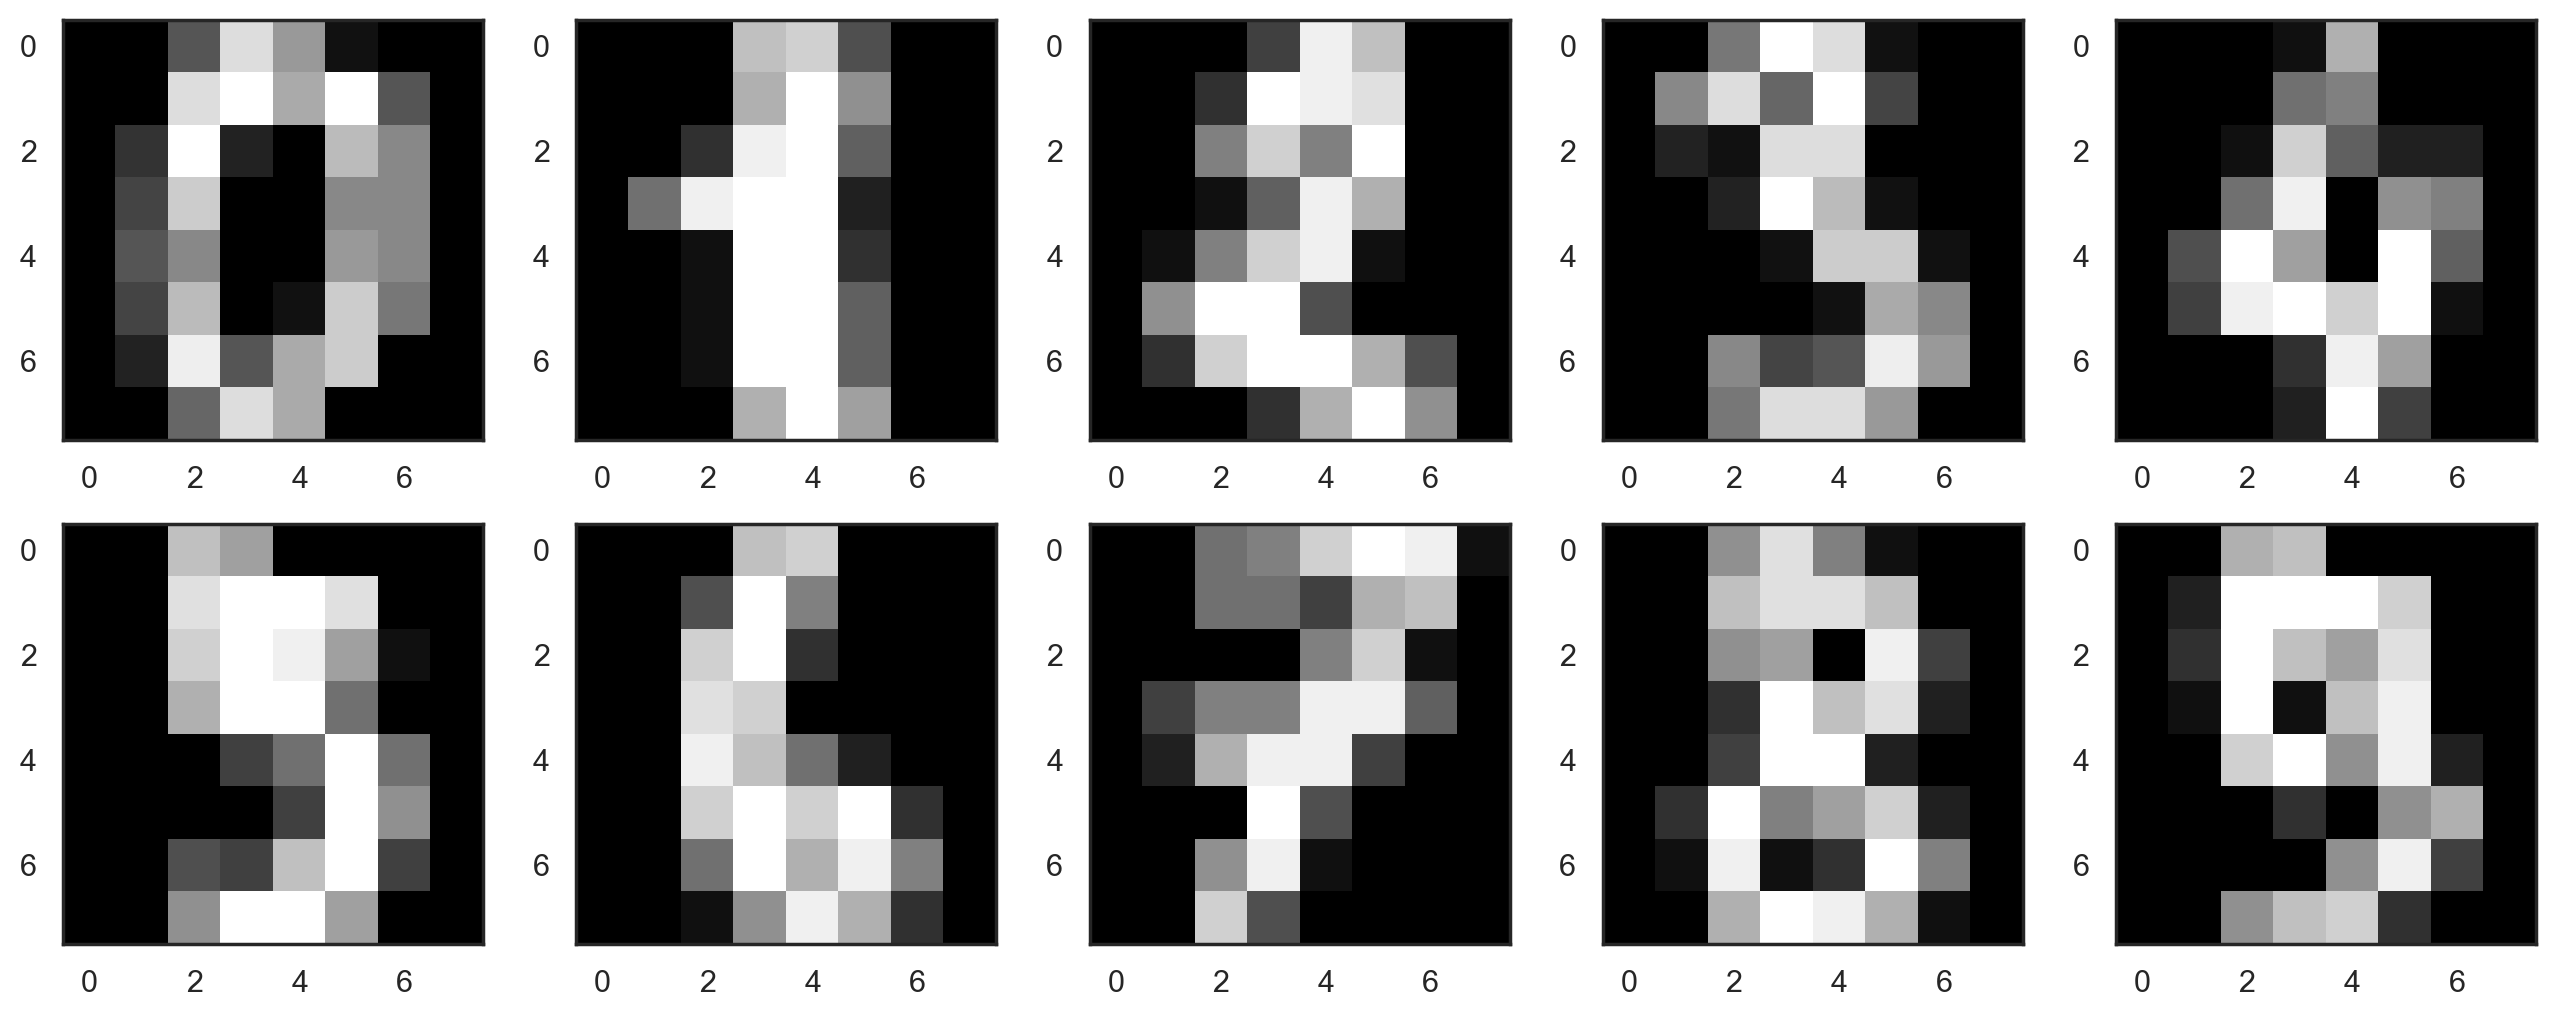

In [9]:
# f, axes = plt.subplots(5, 2, sharey=True, figsize=(16,6))
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i, :].reshape([8, 8]), cmap="gray");

Our data has 64 dimensions, but we are going to reduce it to only 2 and see that, even with just 2 dimensions, we can clearly see that digits separate into clusters.

Projecting 64-dimensional data to 2D


/var/folders/nq/3bg2g91s5f57x9r_hmd76vs40000gn/T/ipykernel_3881/1923420135.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap("nipy_spectral", 10),


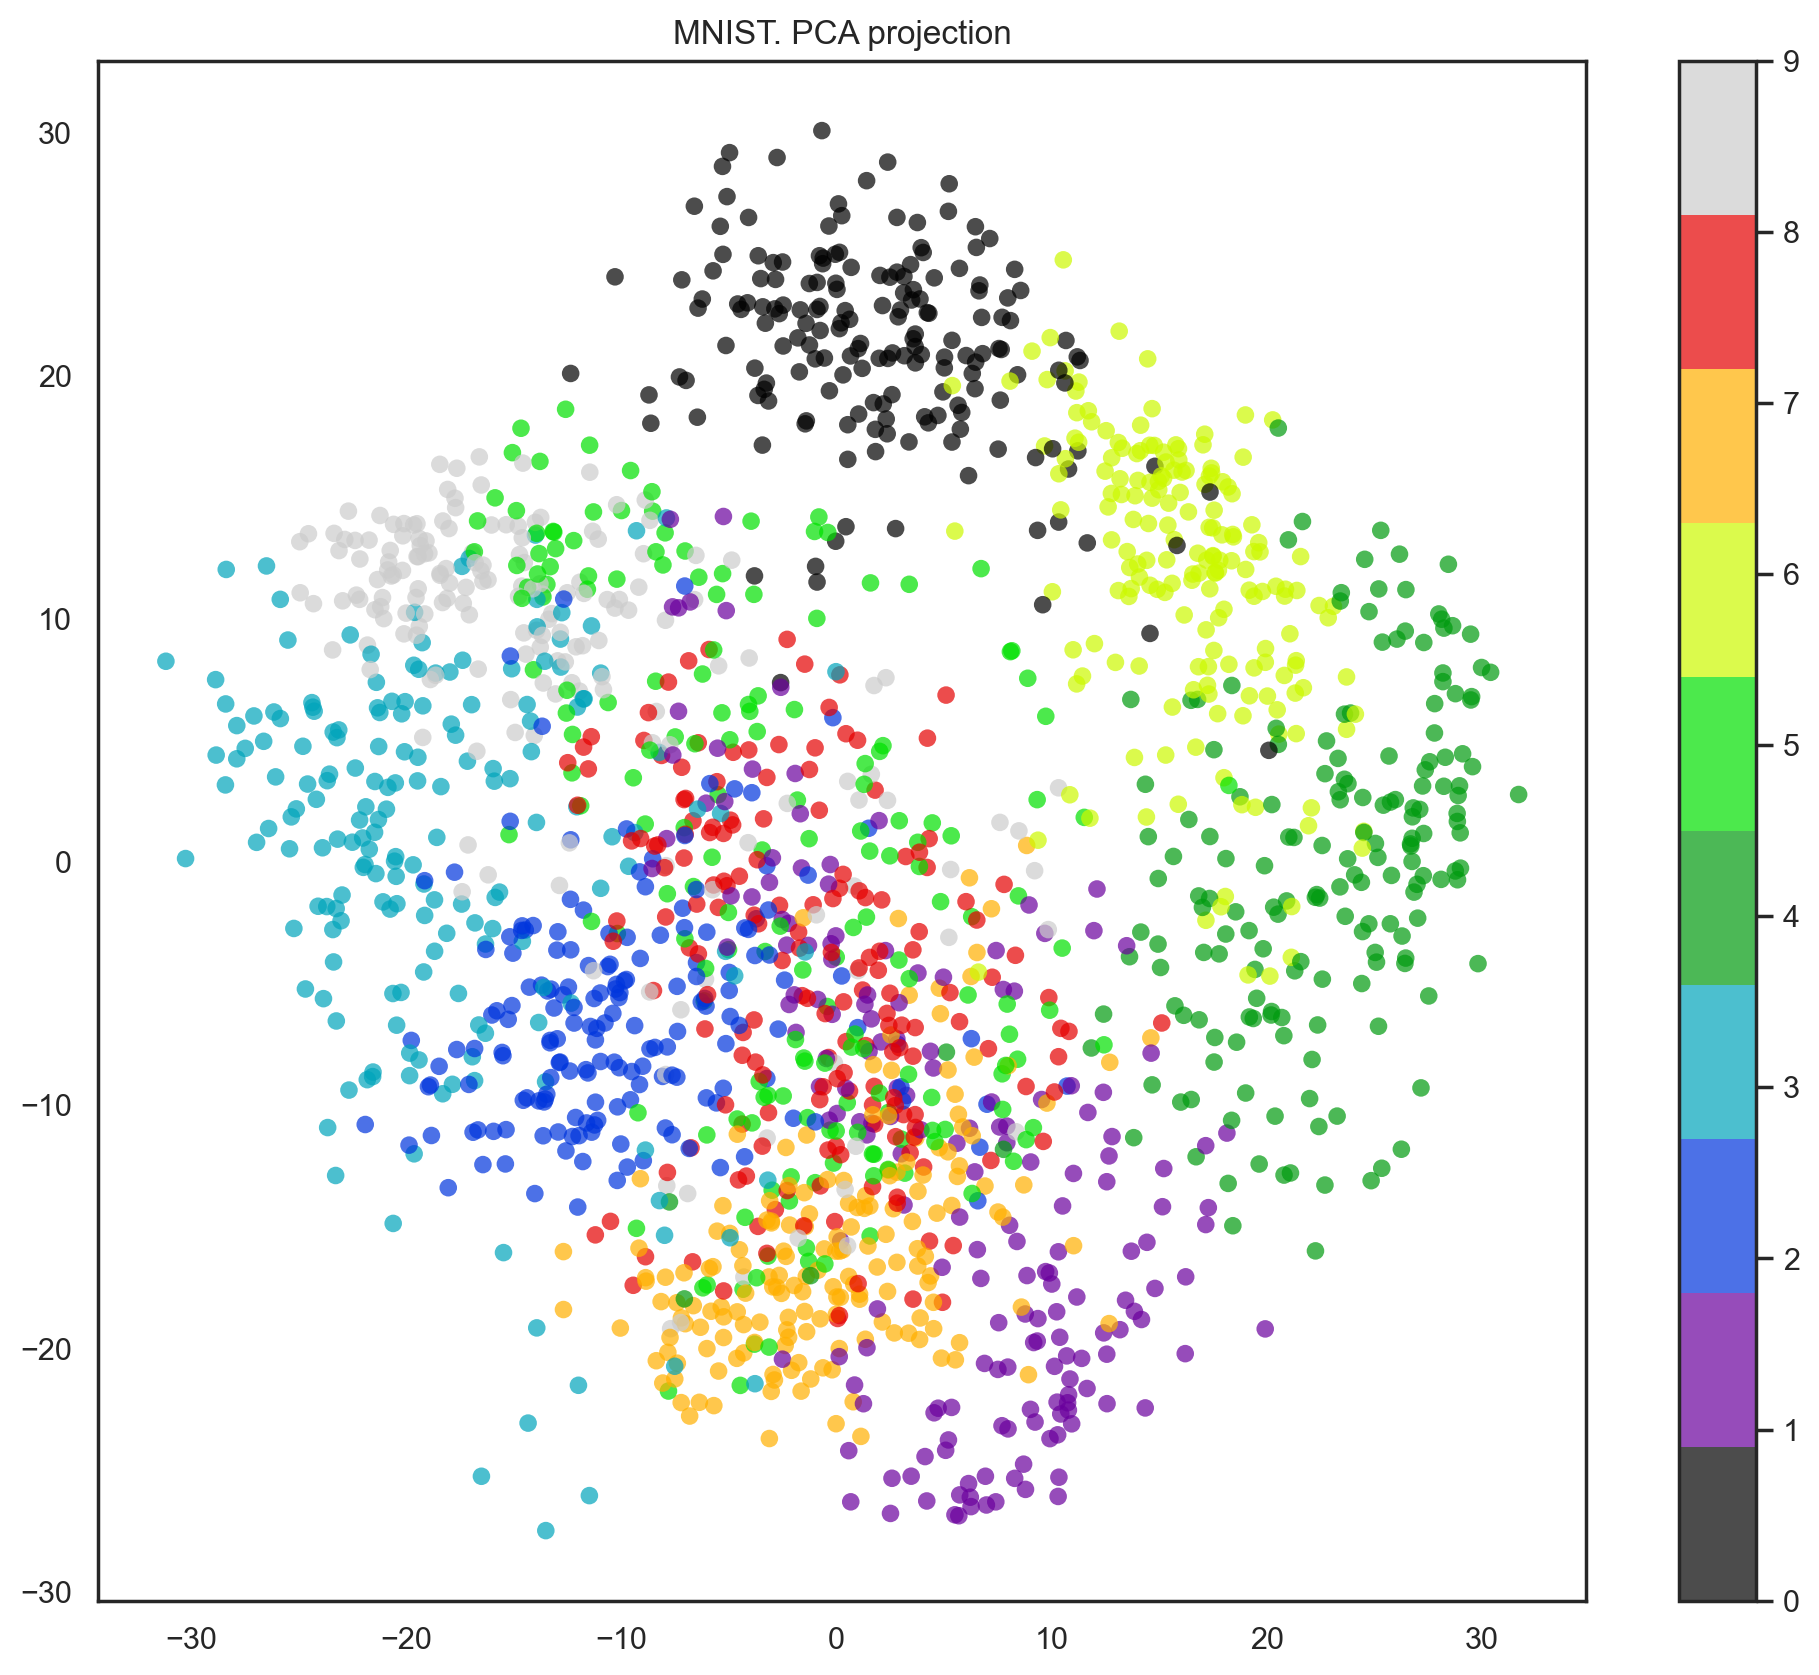

In [10]:
pca = decomposition.PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print("Projecting %d-dimensional data to 2D" % X.shape[1])

plt.figure(figsize=(12, 10))
plt.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=y,
    edgecolor="none",
    alpha=0.7,
    s=40,
    cmap=plt.cm.get_cmap("nipy_spectral", 10),
)
plt.colorbar()
plt.title("MNIST. PCA projection");

Indeed, with t-SNE, the picture looks better since PCA has a linear constraint while t-SNE does not. However, even with such a small dataset, the t-SNE algorithm takes significantly more time to complete than PCA.

/var/folders/nq/3bg2g91s5f57x9r_hmd76vs40000gn/T/ipykernel_3881/3153659053.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap("nipy_spectral", 10),


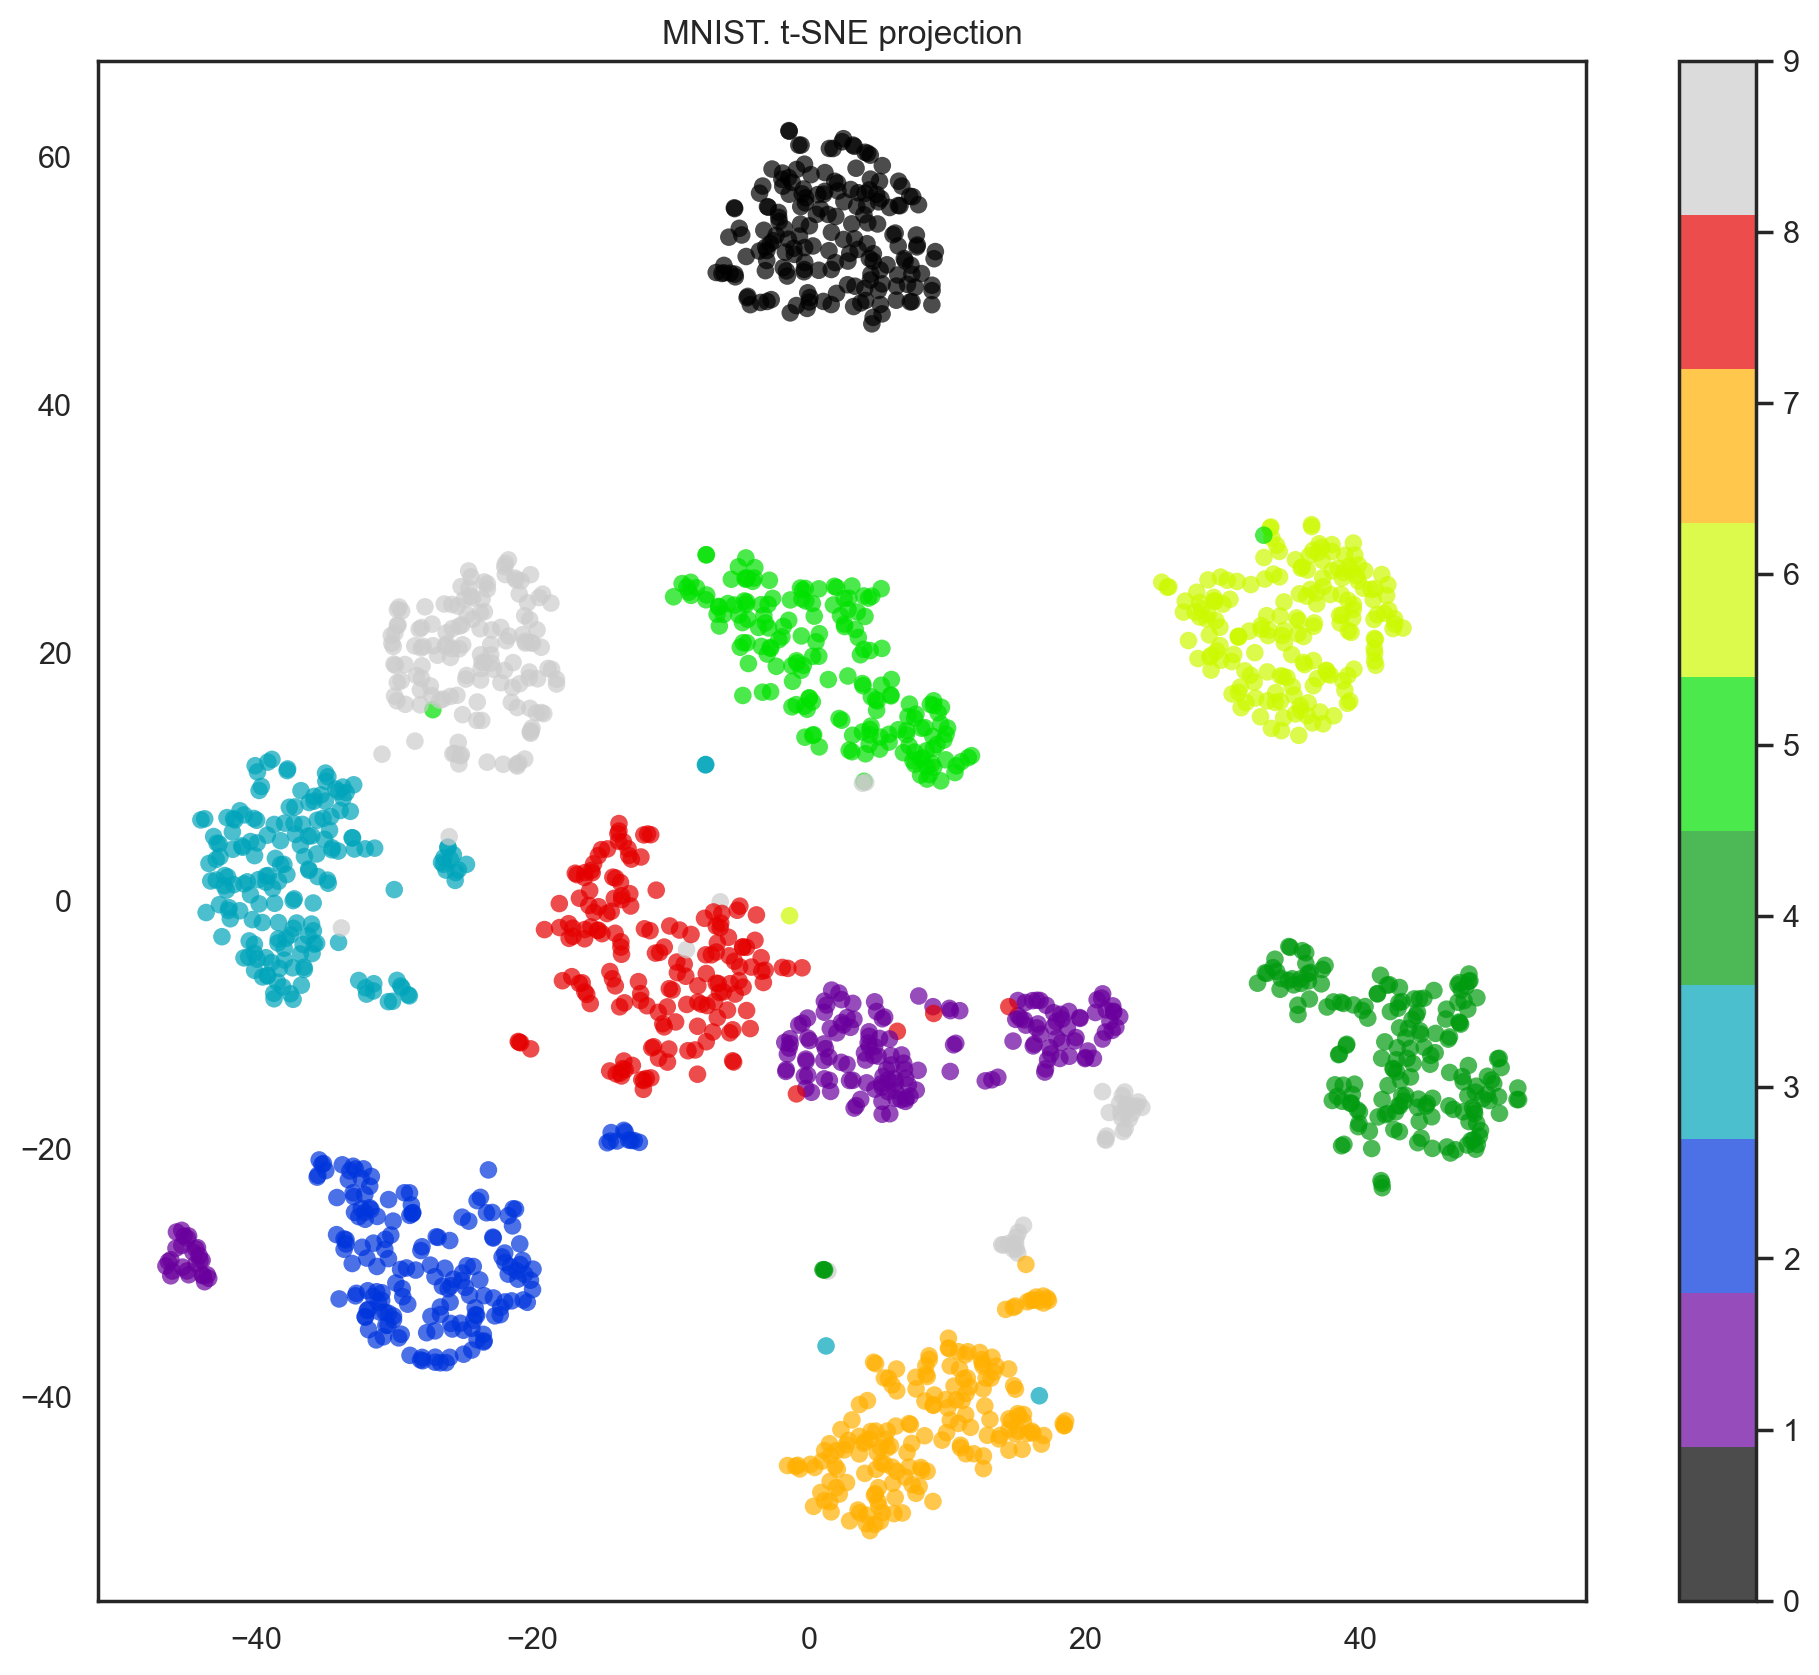

In [11]:
# %%time

from sklearn.manifold import TSNE

tsne = TSNE(random_state=17)

X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(12, 10))
plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=y,
    edgecolor="none",
    alpha=0.7,
    s=40,
    cmap=plt.cm.get_cmap("nipy_spectral", 10),
)
plt.colorbar()
plt.title("MNIST. t-SNE projection");

In practice, we would choose the number of principal components such that we can explain 90% of the initial data dispersion (via the `explained_variance_ratio`). Here, that means retaining 21 principal components; therefore, we reduce the dimensionality from 64 features to 21.

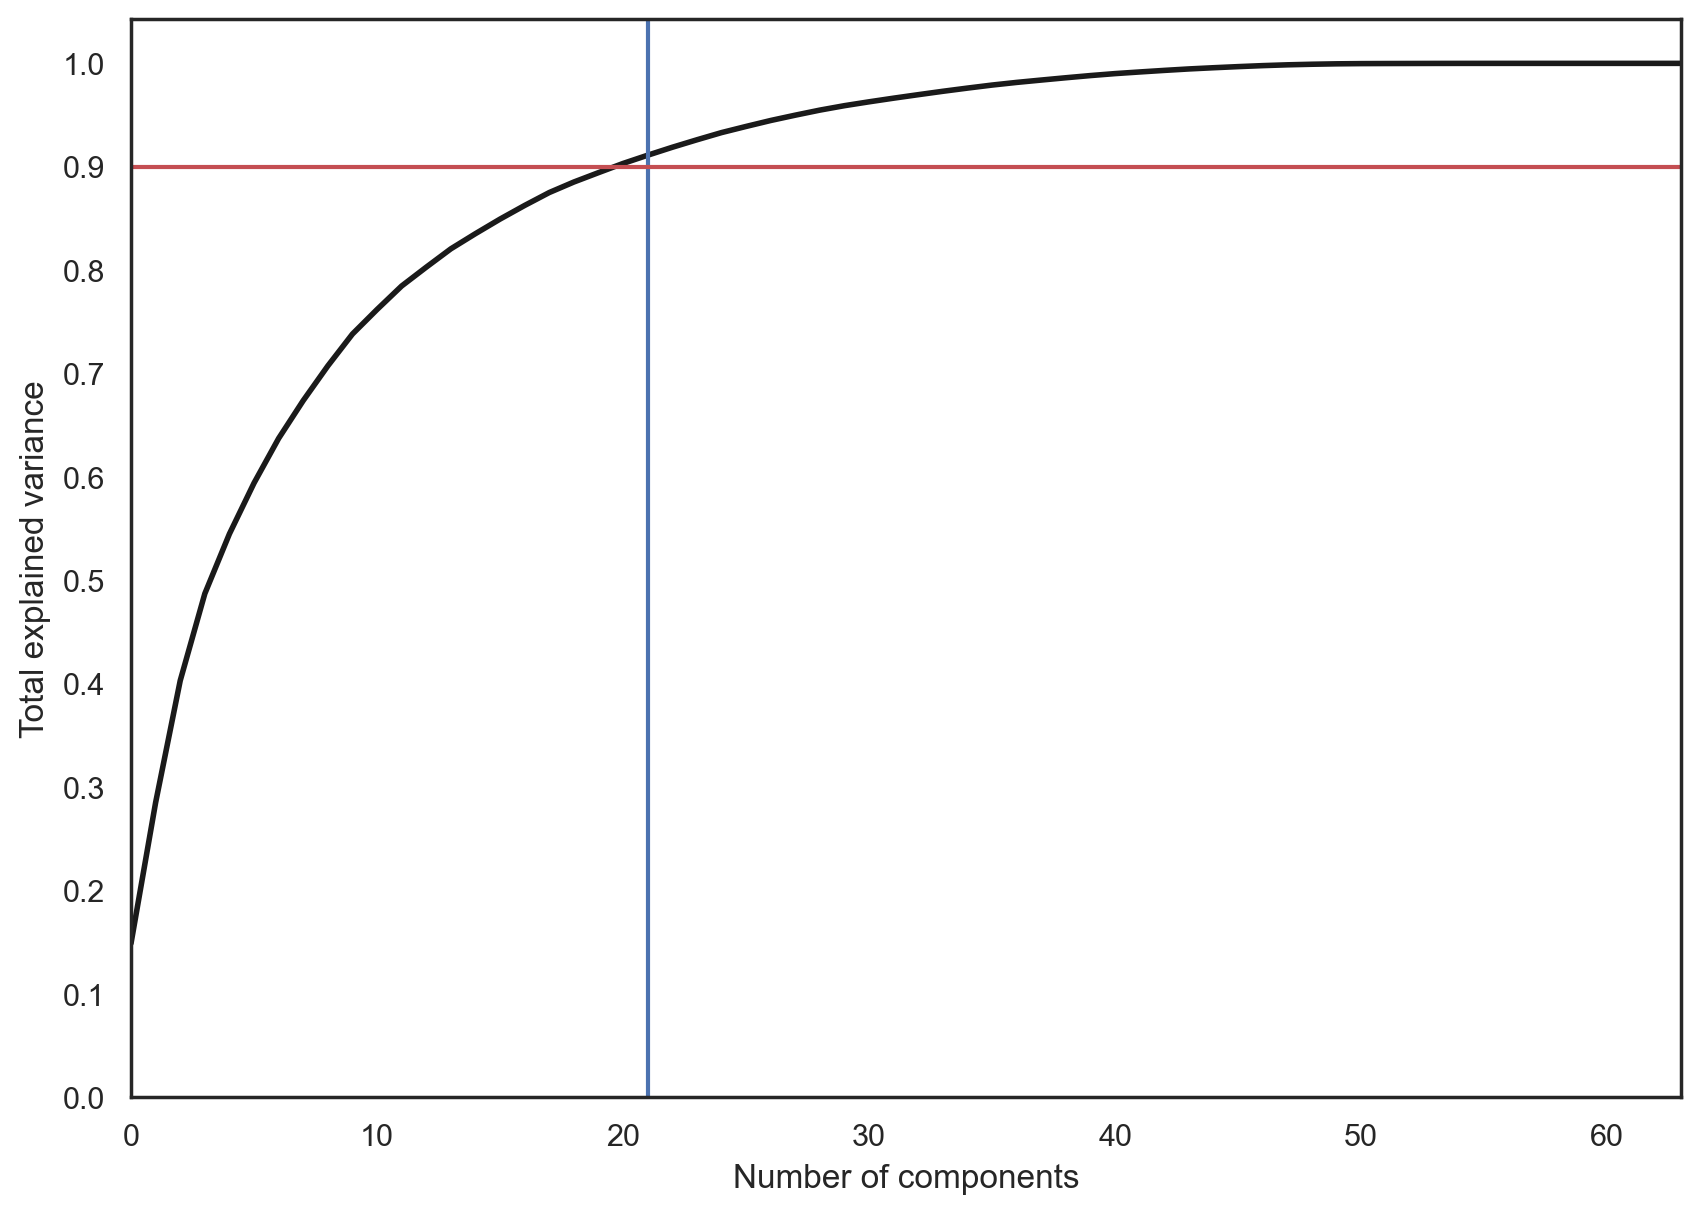

In [12]:
pca = decomposition.PCA().fit(X)

plt.figure(figsize=(10, 7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color="k", lw=2)
plt.xlabel("Number of components")
plt.ylabel("Total explained variance")
plt.xlim(0, 63)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(21, c="b")
plt.axhline(0.9, c="r")
plt.show();

## 2. Clustering

The main idea behind clustering is pretty straightforward. Basically, we say to ourselves, "I have these points here, and I can see that they organize into groups. It would be nice to describe these things more concretely, and, when a new point comes in, assign it to the correct group." This general idea encourages exploration and opens up a variety of algorithms for clustering.

<figure><img align="center" src="https://habrastorage.org/getpro/habr/post_images/8b9/ae5/586/8b9ae55861f22a2809e8b3a00ef815ad.png"><figcaption><it>The examples of the outcomes from different algorithms from scikit-learn</it></figcaption></figure>

The algorithms listed below do not cover all the clustering methods out there, but they are the most commonly used ones.

### K-means

K-means algorithm is the most popular and yet simplest of all the clustering algorithms. Here is how it works:
1. Select the number of clusters $k$ that you think is the optimal number.
2. Initialize $k$ points as "centroids" randomly within the space of our data.
3. Attribute each observation to its closest centroid.
4. Update the centroids to the center of all the attributed set of observations.
5. Repeat steps 3 and 4 a fixed number of times or until all of the centroids are stable (i.e. no longer change in step 4).

This algorithm is easy to describe and visualize. Let's take a look.

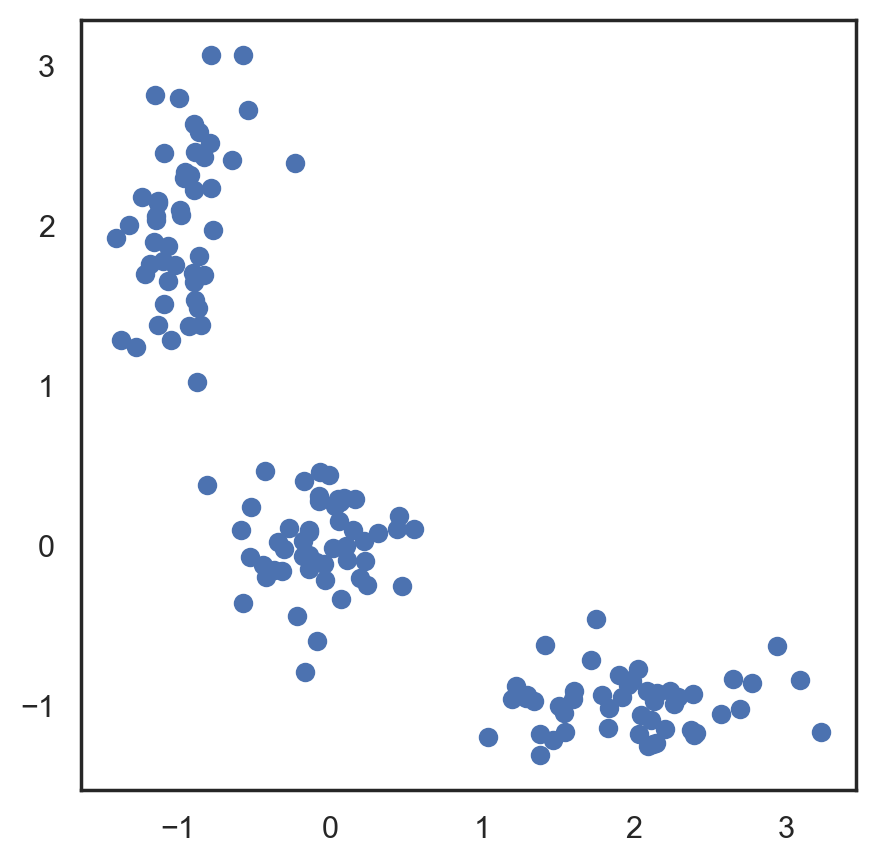

In [13]:
# Let's begin by allocation 3 cluster's points
X = np.zeros((150, 2))

np.random.seed(seed=42)
X[:50, 0] = np.random.normal(loc=0.0, scale=0.3, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=0.3, size=50)

X[50:100, 0] = np.random.normal(loc=2.0, scale=0.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=0.2, size=50)

X[100:150, 0] = np.random.normal(loc=-1.0, scale=0.2, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=0.5, size=50)

plt.figure(figsize=(5, 5))
plt.plot(X[:, 0], X[:, 1], "bo");

In [14]:
# Scipy has function that takes 2 tuples and return
# calculated distance between them
from scipy.spatial.distance import cdist

# Randomly allocate the 3 centroids
np.random.seed(seed=42)
centroids = np.random.normal(loc=0.0, scale=1.0, size=6)
centroids = centroids.reshape((3, 2))

cent_history = []
cent_history.append(centroids)

for i in range(3):
    # Calculating the distance from a point to a centroid
    distances = cdist(X, centroids)
    # Checking what's the closest centroid for the point
    labels = distances.argmin(axis=1)

    # Labeling the point according the point's distance
    centroids = centroids.copy()
    centroids[0, :] = np.mean(X[labels == 0, :], axis=0)
    centroids[1, :] = np.mean(X[labels == 1, :], axis=0)
    centroids[2, :] = np.mean(X[labels == 2, :], axis=0)

    cent_history.append(centroids)

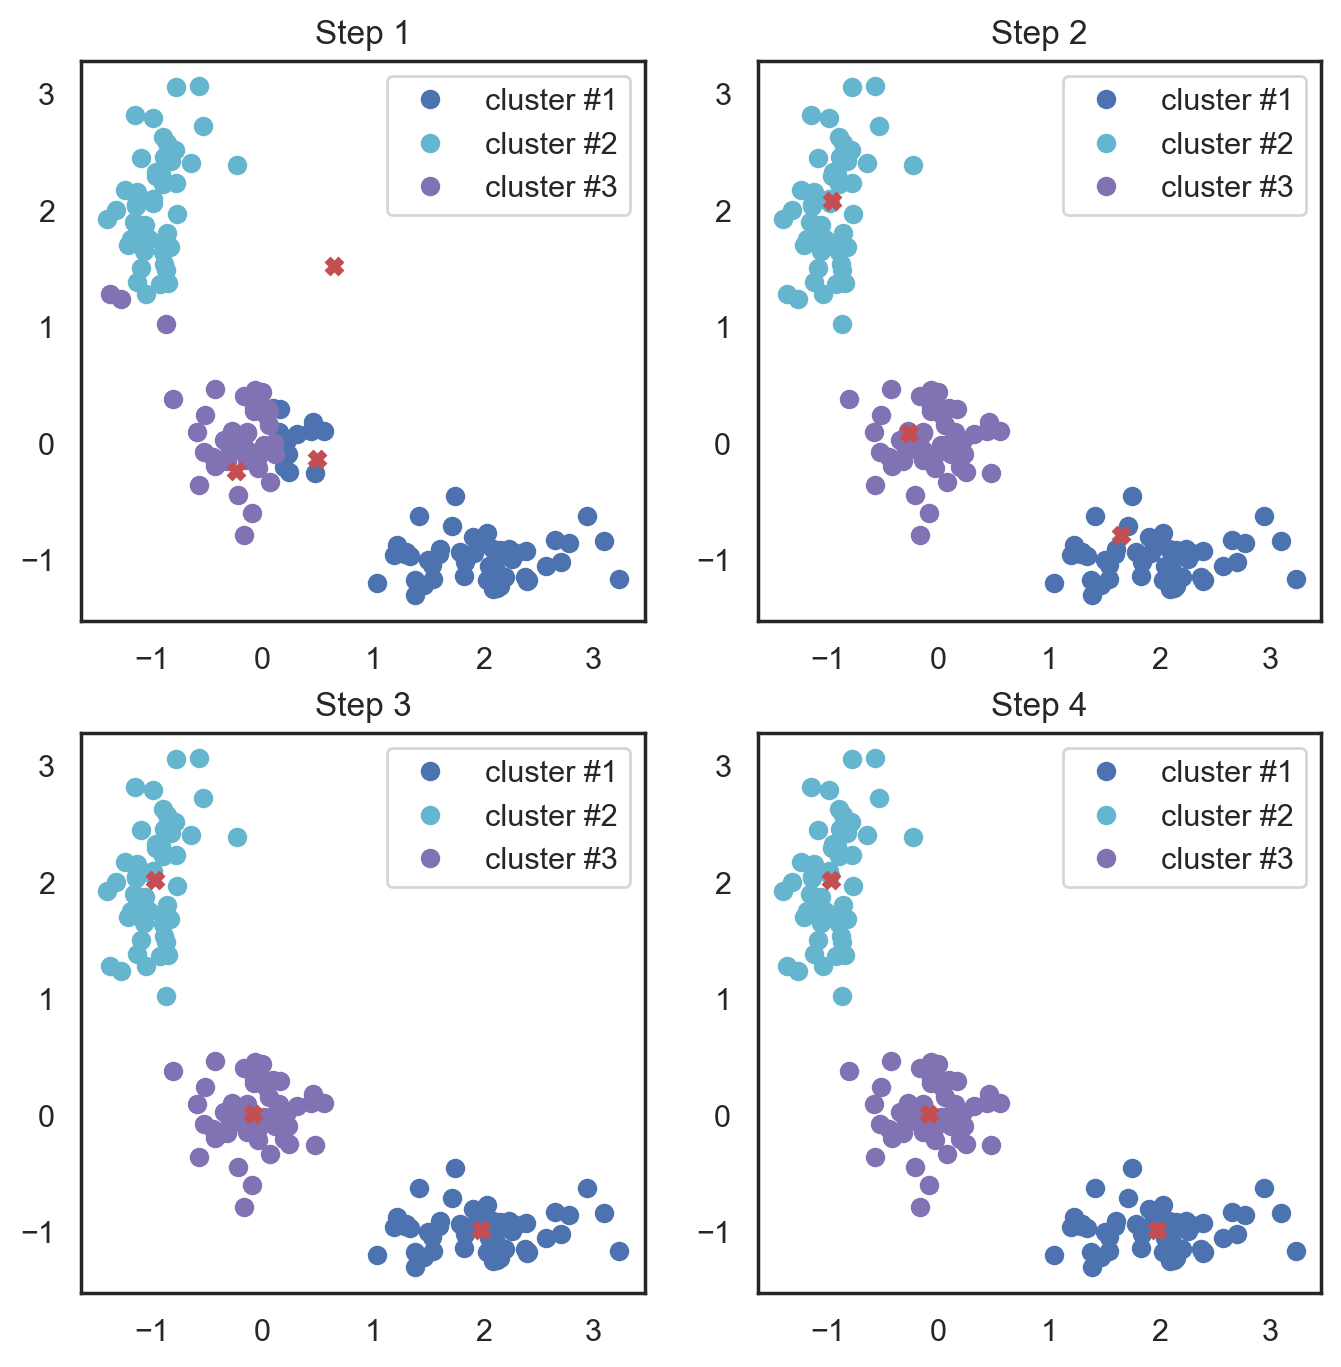

In [15]:
# Let's plot K-means
plt.figure(figsize=(8, 8))
for i in range(4):
    distances = cdist(X, cent_history[i])
    labels = distances.argmin(axis=1)

    plt.subplot(2, 2, i + 1)
    plt.plot(X[labels == 0, 0], X[labels == 0, 1], "bo", label="cluster #1")
    plt.plot(X[labels == 1, 0], X[labels == 1, 1], "co", label="cluster #2")
    plt.plot(X[labels == 2, 0], X[labels == 2, 1], "mo", label="cluster #3")
    plt.plot(cent_history[i][:, 0], cent_history[i][:, 1], "rX")
    plt.legend(loc=0)
    plt.title("Step {:}".format(i + 1));

Here, we used Euclidean distance, but the algorithm will converge with any other metric. You can not only vary the number of steps or the convergence criteria but also the distance measure between the points and cluster centroids.

Another "feature" of this algorithm is its sensitivity to the initial positions of the cluster centroids. You can run the algorithm several times and then average all the centroid results.

## Choosing the number of clusters for K-means

In contrast to the supervised learning tasks such as classification and regression, clustering requires more effort to choose the optimization criterion. Usually, when working with k-means, we optimize the sum of squared distances between the observations and their centroids.

$$ J(C) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C,$$

where $C$ – is a set of clusters with power $K$, $\mu_k$ is a centroid of a cluster $C_k$.

This definition seems reasonable -- we want our observations to be as close to their centroids as possible. But, there is a problem -- the optimum is reached when the number of centroids is equal to the number of observations, so you would end up with every single observation as its own separate cluster.

In order to avoid that case, we should choose a number of clusters after which a function $J(C_k)$ is decreasing less rapidly. More formally,

$$ D(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_k)|}  \rightarrow \min\limits_k$$

Let's look at an example.

In [16]:
from sklearn.cluster import KMeans

In [17]:
inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1, n_init='auto').fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

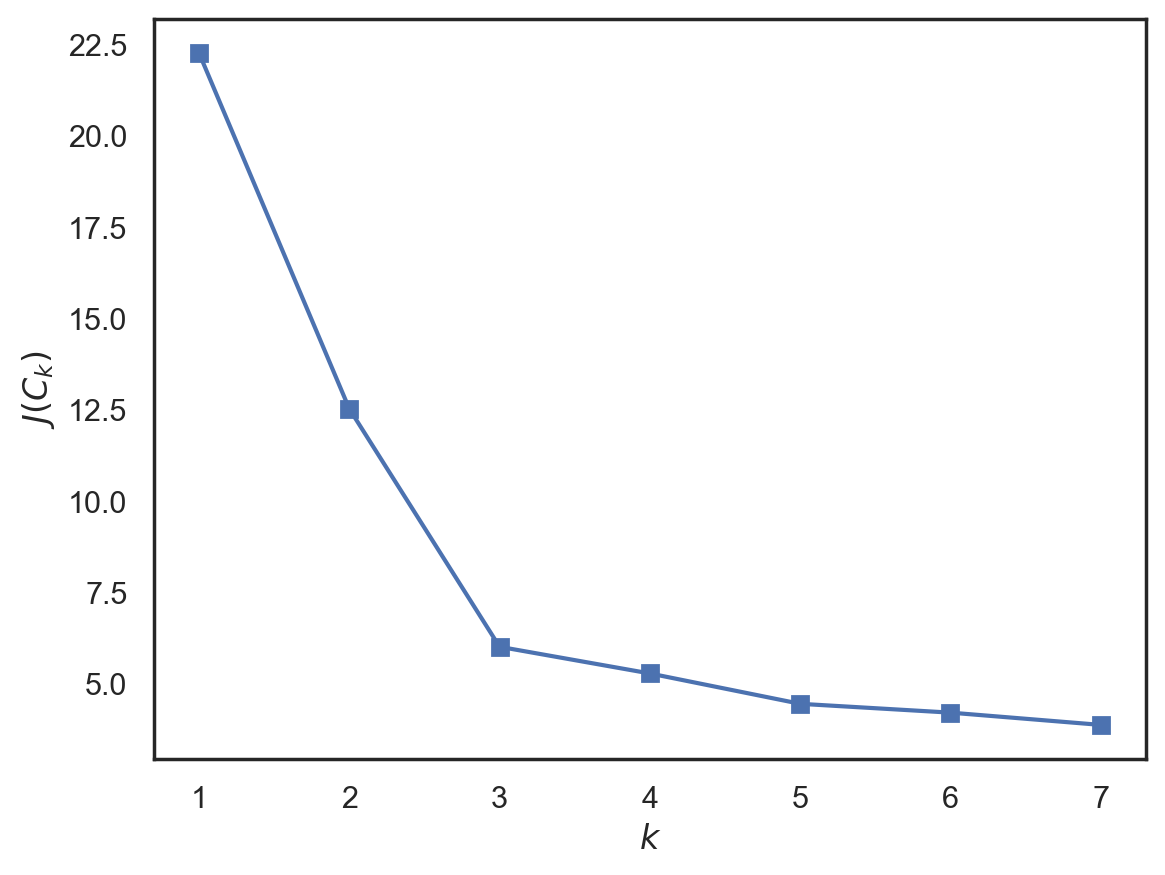

In [18]:
plt.plot(range(1, 8), inertia, marker="s")
plt.xlabel("$k$")
plt.ylabel("$J(C_k)$");

We see that $J(C_k)$ decreases significantly until the number of clusters is 3 and then does not change as much anymore. This means that the optimal number of clusters is 3.

### Issues

Inherently, K-means is NP-hard. For $d$ dimensions, $k$ clusters, and $n$ observations, we will find a solution in $O(n^{d k+1})$ time. There are some heuristics to deal with this; an example is MiniBatch K-means, which takes portions (batches) of data instead of fitting the whole dataset and then moves centroids by taking the average of the previous steps. Compare the implementation of K-means and MiniBatch K-means in the [scikit-learn documentation](http://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html).

The [implementation](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) of the algorithm using `scikit-learn` has its benefits such as the possibility to state the number of initializations with the `n_init` function parameter, which enables us to identify more robust centroids. Moreover, these runs can be done in parallel to decrease the computation time.